# Evaluation: Extrapolate the learning curve with a cutoff

In [130]:
import h5py
import numpy as np
import sklearn.metrics as metrics
import torch
import random
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import lcpfn 
from lcpfn import bar_distribution, encoders, train
from lcpfn import train as lctrain

### Load LCDB 1.1 data

In [131]:
### hyperparameter
OPENML_ID = {0: '3', 1: '6', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '26', 14: '28', 15: '29', 16: '30', 17: '31', 18: '32', 19: '36', 20: '37', 21: '38', 22: '44', 23: '46', 24: '50', 25: '54', 26: '55', 27: '57', 28: '60', 29: '61', 30: '151', 31: '179', 32: '180', 33: '181', 34: '182', 35: '184', 36: '185', 37: '188', 38: '201', 39: '273', 40: '293', 41: '299', 42: '300', 43: '307', 44: '336', 45: '346', 46: '351', 47: '354', 48: '357', 49: '380', 50: '389', 51: '390', 52: '391', 53: '392', 54: '393', 55: '395', 56: '396', 57: '398', 58: '399', 59: '401', 60: '446', 61: '458', 62: '469', 63: '554', 64: '679', 65: '715', 66: '718', 67: '720', 68: '722', 69: '723', 70: '727', 71: '728', 72: '734', 73: '735', 74: '737', 75: '740', 76: '741', 77: '743', 78: '751', 79: '752', 80: '761', 81: '772', 82: '797', 83: '799', 84: '803', 85: '806', 86: '807', 87: '813', 88: '816', 89: '819', 90: '821', 91: '822', 92: '823', 93: '833', 94: '837', 95: '843', 96: '845', 97: '846', 98: '847', 99: '849', 100: '866', 101: '871', 102: '881', 103: '897', 104: '901', 105: '903', 106: '904', 107: '910', 108: '912', 109: '913', 110: '914', 111: '917', 112: '923', 113: '930', 114: '934', 115: '953', 116: '958', 117: '959', 118: '962', 119: '966', 120: '971', 121: '976', 122: '977', 123: '978', 124: '979', 125: '980', 126: '991', 127: '993', 128: '995', 129: '1000', 130: '1002', 131: '1018', 132: '1019', 133: '1020', 134: '1021', 135: '1036', 136: '1040', 137: '1041', 138: '1042', 139: '1049', 140: '1050', 141: '1053', 142: '1056', 143: '1063', 144: '1067', 145: '1068', 146: '1069', 147: '1083', 148: '1084', 149: '1085', 150: '1086', 151: '1087', 152: '1088', 153: '1116', 154: '1119', 155: '1120', 156: '1128', 157: '1130', 158: '1134', 159: '1138', 160: '1139', 161: '1142', 162: '1146', 163: '1161', 164: '1166', 165: '1216', 166: '1233', 167: '1235', 168: '1236', 169: '1441', 170: '1448', 171: '1450', 172: '1457', 173: '1461', 174: '1462', 175: '1464', 176: '1465', 177: '1468', 178: '1475', 179: '1477', 180: '1478', 181: '1479', 182: '1480', 183: '1483', 184: '1485', 185: '1486', 186: '1487', 187: '1488', 188: '1489', 189: '1494', 190: '1497', 191: '1499', 192: '1501', 193: '1503', 194: '1509', 195: '1510', 196: '1515', 197: '1566', 198: '1567', 199: '1575', 200: '1590', 201: '1592', 202: '1597', 203: '4134', 204: '4135', 205: '4137', 206: '4534', 207: '4538', 208: '4541', 209: '6332', 210: '23381', 211: '23512', 212: '23517', 213: '40498', 214: '40499', 215: '40664', 216: '40668', 217: '40670', 218: '40672', 219: '40677', 220: '40685', 221: '40687', 222: '40701', 223: '40713', 224: '40900', 225: '40910', 226: '40923', 227: '40927', 228: '40966', 229: '40971', 230: '40975', 231: '40978', 232: '40979', 233: '40981', 234: '40982', 235: '40983', 236: '40984', 237: '40994', 238: '40996', 239: '41027', 240: '41142', 241: '41143', 242: '41144', 243: '41145', 244: '41146', 245: '41150', 246: '41156', 247: '41157', 248: '41158', 249: '41159', 250: '41161', 251: '41163', 252: '41164', 253: '41165', 254: '41166', 255: '41167', 256: '41168', 257: '41169', 258: '41228', 259: '41972', 260: '42734', 261: '42742', 262: '42769', 263: '42809', 264: '42810'}
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Tree', 5: 'ExtraTree', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}
ANCHOR_SIZE = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

### load data: validation accuracy
lc_data = h5py.File(Path.cwd() / 'dataset/LCDB11_ACC_265_noFS_raw.hdf5', 'r')['accuracy'][...][:,:,:,:,:,1]

mean_valid_lc_nofs =np.nanmean(lc_data, axis=(2, 3))

In [132]:
### dataset split
experiment = 4
data_split_state = 42
trained_on = "ExtraTree"
eval_on = trained_on
train_data_indices, test_data_indices = train_test_split(np.arange(len(OPENML_ID)), 
                                                         test_size=0.2, 
                                                         random_state=data_split_state)
AUGMENT = True
augment_string = "no_augment"
if AUGMENT:
    augment_string = "augment"

groups = {
    "SVC": [0, 1, 2, 3],
    "Trees": [4, 5, 20, 21, 22],
    "NB": [14, 15, 16, 17],
    "Neighbors": [18, 19],
    "DA": [12, 13],
    "Linear": [6, 7, 8, 9, 10],
    "nn": [11],
    "Dummy": [23],
    "QDA": [13],
    "LDA": [12],
    "Sigmoid": [3],
    "Centroid": [19],
    "Gradient": [22],
    "ExtraTree": [5]
}

### learner split
train_learner_indices = np.array(groups[trained_on])    
test_learner_indices = np.array(groups[eval_on])    

### UD, UL, UDUL
train_data = lc_data[train_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UD = lc_data[test_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UL = lc_data[train_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UDUL = lc_data[test_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)

print(f"Train data shape: {train_data.shape}")  
print(f"Test data UD shape: {test_data_UD.shape}")
print(f"Test data UL shape: {test_data_UL.shape}")
print(f"Test data UDUL shape: {test_data_UDUL.shape}")

Train data shape: (5300, 1, 137)
Test data UD shape: (1325, 1, 137)
Test data UL shape: (5300, 1, 137)
Test data UDUL shape: (1325, 1, 137)


### Load trained LC-PFN model

In [133]:
model_dir = f"models_experiment{experiment}/{trained_on}/lcpfn_{trained_on}_state{data_split_state}_300_{augment_string}.pth"
print(model_dir)
model = torch.load(model_dir, weights_only=False)
model.eval()  

models_experiment4/ExtraTree/lcpfn_ExtraTree_state42_300_augment.pth


TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Sequential(
    (0): Normalize()
    (1): Normalize()
    (2): Linear(in_features=1, out_features=128, bias=True)
  )
  (y_encoder): Sequential(
    (0): Normalize()
    (1): Linear(in_features=1, out_features=128, bias=True)
  )
  (pos_encoder): NoPos

### Inference 

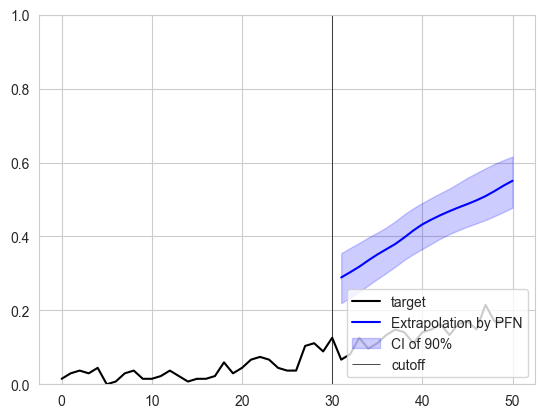

In [134]:
random_idx = 0
curve = train_data[random_idx]  # (1, 137)
curve = curve[~np.isnan(curve)]

y = torch.from_numpy(curve).float().unsqueeze(-1)
x = torch.arange(1, y.shape[0] + 1).unsqueeze(-1).float()  

# construct 
num_last_anchor = 20
cutoff = len(curve) - num_last_anchor

x_train = x[:cutoff]
y_train = y[:cutoff]
x_test = x[cutoff:]
qs = [0.05, 0.5, 0.95]

normalizer = lcpfn.utils.identity_normalizer()

y_train_norm = normalizer[0](y_train)

# forward
single_eval_pos = x_train.shape[0]
x = torch.cat([x_train, x_test], dim=0).unsqueeze(1)
y = y_train.unsqueeze(1)

logits = model((x, y), single_eval_pos=single_eval_pos)

predictions = normalizer[1](
    torch.cat([model.criterion.icdf(logits, q) for q in qs], dim=1)
)

x_test_np = x[cutoff:].detach().cpu().numpy().flatten()
pred_mean = predictions[:, 1].detach().cpu().numpy()
pred_lower = predictions[:, 0].detach().cpu().numpy()
pred_upper = predictions[:, 2].detach().cpu().numpy()

# plot
plt.plot(curve, "black", label="target")
plt.plot(x_test_np, pred_mean, "blue", label="Extrapolation by PFN")
plt.fill_between(x_test_np, pred_lower, pred_upper, color="blue", alpha=0.2, label="CI of 90%")
plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()

### design your own metrics to evaluate

In [135]:
mean_absolute_errors = []
CI_sizes = []
percent_inside_CI = []
#test_data_UD.shape[0] -1
for i in range(0, test_data_UDUL.shape[0] - 1):
    curve = test_data_UDUL[i]  # (1, 137)
    curve = curve[~np.isnan(curve)]
    
    y = torch.from_numpy(curve).float().unsqueeze(-1)
    x = torch.arange(1, y.shape[0] + 1).unsqueeze(-1).float()  
    
    if len(curve) <= 20:
        continue
    
    # construct 
    num_last_anchor = 20
    cutoff = len(curve) - num_last_anchor
    
    x_train = x[:cutoff]
    y_train = y[:cutoff]
    x_test = x[cutoff:]
    qs = [0.05, 0.5, 0.95]
    
    normalizer = lcpfn.utils.identity_normalizer()
    
    y_train_norm = normalizer[0](y_train)
    
    # forward
    single_eval_pos = x_train.shape[0]
    x = torch.cat([x_train, x_test], dim=0).unsqueeze(1)
    y = y_train.unsqueeze(1)
    
    logits = model((x, y), single_eval_pos=single_eval_pos)
    
    predictions = normalizer[1](
        torch.cat([model.criterion.icdf(logits, q) for q in qs], dim=1)
    )
    
    x_test_np = x[cutoff:].detach().cpu().numpy().flatten()
    pred_mean = predictions[:, 1].detach().cpu().numpy()
    pred_lower = predictions[:, 0].detach().cpu().numpy()
    pred_upper = predictions[:, 2].detach().cpu().numpy()
    curve_real_values = curve[cutoff:]
    
    # For every anchor in the extrapolation compute mse and size of confidence interval
    n = len(x_test_np)
    curve_avg_CI_size = np.average(pred_upper-pred_lower)
    curve_mae = metrics.mean_absolute_error(curve_real_values, pred_mean)
    curve_inside_CI = np.average(np.where((pred_upper > curve_real_values) & (curve_real_values > pred_lower),1,0))
    if i%100 == 0:
        print(i)
    
    mean_absolute_errors.append(curve_mae)
    CI_sizes.append(curve_avg_CI_size)
    percent_inside_CI.append(curve_inside_CI)
    
print("Done")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
Done


#### Aggregate the data and make relevant plots

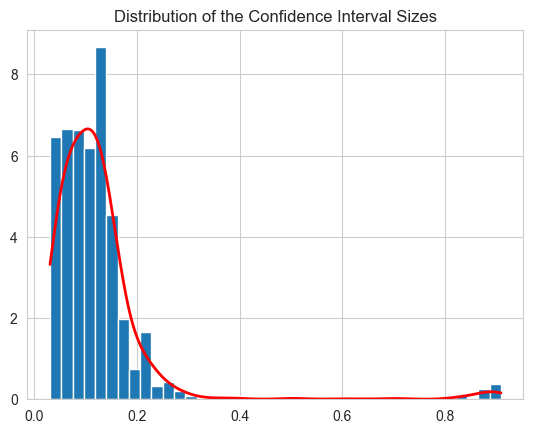

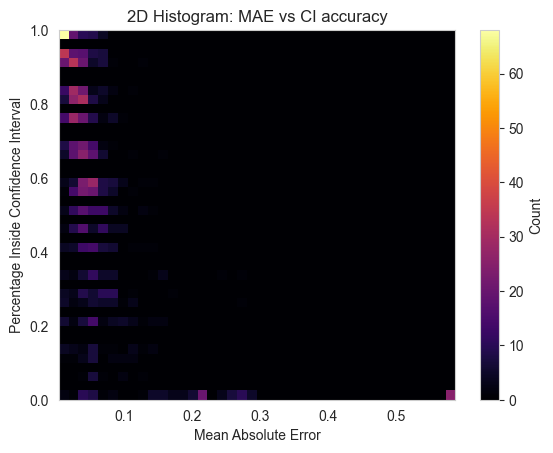

In [136]:
avg_MAE = np.average(mean_absolute_errors)
avg_CI_sizes = np.average(CI_sizes)
avg_percent_in_CI = np.average(percent_inside_CI)

def create_CI_plot():
    plt.hist(CI_sizes, bins=40, density=True)
    plt.title("Distribution of the Confidence Interval Sizes")
    
    kde = scipy.stats.gaussian_kde(CI_sizes)
    x_vals = np.linspace(min(CI_sizes), max(CI_sizes), 500)
    plt.plot(x_vals, kde(x_vals), 'r-', linewidth=2, label='KDE')

def create_MEA_PercentCI():
    plt.hist2d(x=mean_absolute_errors, 
           y=percent_inside_CI, 
           bins=(40,40), 
           cmap='inferno')
    plt.colorbar(label='Count')
    plt.xlabel('Mean Absolute Error')
    plt.ylabel('Percentage Inside Confidence Interval')
    plt.title('2D Histogram: MAE vs CI accuracy')


create_CI_plot()
plt.show()

create_MEA_PercentCI()
plt.show()
# plt.hlines(avg_percent_out_CI)


# # plot
# plt.plot(curve, "black", label="target")
# plt.plot(x_test_np, pred_mean, "blue", label="Extrapolation by PFN")
# plt.fill_between(x_test_np, pred_lower, pred_upper, color="blue", alpha=0.2, label="CI of 90%")
# plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
# plt.ylim(0, 1)
# plt.legend(loc="lower right")
# plt.show()

#### Save results to file

In [137]:
import os

directory = f"experiment{experiment}/trained{trained_on}/eval{eval_on}/state{data_split_state}{augment_string}"
os.makedirs(directory, exist_ok=True)

with open(f"{directory}/data_summary.txt", "w") as f:
    f.write(mean_absolute_errors.__str__())
    f.write("\n")
    f.write(avg_MAE.__str__())
    f.write("\n")
    f.write(percent_inside_CI.__str__())
    f.write("\n")
    f.write(avg_percent_in_CI.__str__())
    f.write("\n")
    f.write(CI_sizes.__str__())
    f.write("\n")
    f.write(avg_CI_sizes.__str__())
    f.write("\n")
    f.write(model_dir)
    
    
create_CI_plot()
plt.savefig(f"{directory}/ci_sizes.png")
plt.close()

create_MEA_PercentCI()
plt.savefig(f"{directory}/MEA_vs_PercentInCI")
plt.close()

#### Model equality test used for testing seeding

source: https://discuss.pytorch.org/t/check-if-models-have-same-weights/4351/6

In [138]:
# model_a = torch.load("models_experiment3/QDA/lcpfn_QDA_state42_300_augment.pth", weights_only=False)
# model_b = torch.load("models_experiment2/QDA/lcpfn_QDA_state42_300_augment.pth", weights_only=False)
# model_a.eval()  
# model_b.eval()
# 
# def compare_models(model_1, model_2):
#     models_differ = 0
#     for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
#         if torch.equal(key_item_1[1], key_item_2[1]):
#             pass
#         else:
#             models_differ += 1
#             if (key_item_1[0] == key_item_2[0]):
#                 print('Mismtach found at', key_item_1[0])
#             else:
#                 raise Exception
#     if models_differ == 0:
#         print('Models match perfectly! :)')
# 
# compare_models(model_a, model_b)